In [1]:
import numpy as np
import pandas as pd
from numpy import pi, r_
import matplotlib.pyplot as plt
from scipy import optimize
from matplotlib import rc
import matplotlib.ticker as mtick
import re
import sys
import os
import math
#import decimal
from scipy.optimize import minimize

In [2]:
font = {'size'   : 16}
rc('font', **font)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["lines.linewidth"]=2

#inputfile=sys.argv[1] # ACFs
#mutant=sys.argv[2] # name of the molelule
#plotting=bool(int(sys.argv[3])) # plots should be created ?

plotting=True # plots should be created ?
subplots=True
pico=1.*10**(-12) # picoseconds

In [3]:
# file with QUADRIC analysis of the protein backbone --> has to be done before methyl analysis!!!

inputpath = "."

### CHANGE ACCORDINGLY !!! :
mutant='CI2_WT' # name of the molelule
tumbling = "iso" # iso/ani
outputpath = inputpath+"/"+mutant+"/"+tumbling
## CREATE OUTPUT FOLDER !!! 

tumbling_file=inputpath+"/analysis_"+tumbling+"_"+mutant
inputfile_rates=inputpath+"/"+mutant+"_sch_times.csv"

In [4]:
# Larmor frquency of deuterium
omega_D_600=2.*pi*92.1298227037992*1000000 # @600 MHz
omega_D_750=2.*pi*115.138869111022*1000000 # @750 MHz
# frequencies of spectral density used for the fit / usually frequencies measured in NMR

# !!! create array with five frequences  
measuredfreq_600=np.array([i*omega_D_600 for i in [0,1,2]])
measuredfreq_750=np.array([i*omega_D_750 for i in [0,1,2]])

#measuredfreq = np.concatenate((measuredfreq_600, measuredfreq_750))
measuredfreq = np.array([measuredfreq_600[0], measuredfreq_750[0],measuredfreq_600[1], measuredfreq_750[1],
               measuredfreq_600[2], measuredfreq_750[2]])

frequency = np.linspace(0, 2*10**9, 100)
# prefector
pre=2*np.pi*167000

In [5]:
# functions to calculate methyl relaxation rates from spectral density points
def R1(x,y,z):
    return 3./16.*pre**2*(0*x+ 1*y+4*z)
def R3(x,y,z):                            # R2 <-> R3  !!!
    return 3./16.*pre**2*(0*x+ 3*y+0*z)
def R2(x,y,z):
    return 1./32.*pre**2*(9*x+15*y+6*z)
def R4(x,y,z):
    return 3./16.*pre**2*(0*x+ 1*y+2*z)

# functios to calculate spectral density points from methyl relaxation rates

A = 3./16.*pre**2
B = 1./32.*pre**2
#print (A, B)
def J_omega_D(R1,R2,R3):
    return R3/(3*A) - R1*0 - R2*0

def J_2omega_D(R1,R2,R3):
    return (R1/A - R3/(3*A))/4 - R2*0
def J_2omega_D_b(R2,R3,R4):
    return (R4/A - R3/(3*A))/2 - R2*0  # return (R4/A - R3/(3*A))/2 - R2*0

def J_0(R1,R2,R3):
    return ( R2/B - 5*R3/A - 1.5*R1/A + 0.5*R3/A ) /9
def J_0_b(R2,R3,R4):
    return ( R2/B - 5*R3/A - 3*R4/A + R3/A ) /9


# calculate Aikaike information criterion
def CHIsq(Rmodel,Rnmr,Rerror):
    return sum([((Rmodel[i]-Rnmr[i])/Rerror[i])**2 for i in [0,1,2]])
# indices of strings for output file
indices=["R1spec_600","R2spec_600","R3spec_600","R1spec_750","R2spec_750","R3spec_750", 
         "SLS2","taufLS2","R1LS2_600","R2LS2_600","R3LS2_600","R1LS2_750","R2LS2_750","R3LS2_750",
         "Jw1LS2_600","Jw2LS2_600","Jw3LS2_600","Jw1LS2_750","Jw2LS2_750","Jw3LS2_750",
         "SLS3","taurLS3","taufLS3","R1LS3_600","R2LS3_600","R3LS3_600","R1LS3_750","R2LS3_750","R3LS3_750",
         "Jw1LS3_600","Jw2LS3_600","Jw3LS3_600","Jw1LS3_750","Jw2LS3_750","Jw3LS3_750","AIC_LS2","AIC_LS3"]
# create empty dataframe of order parameter
order=pd.DataFrame()

data1 = pd.read_csv(inputfile_rates, sep=",", index_col=[0])
test1= np.size(data1,0)

def STDV(J1,J2_600,J3_600,J2_750,J3_750,J1LS,J2_600LS,J3_600LS,J2_750LS,J3_750LS):
    return math.sqrt(((J1-J1LS)**2+(J2_600-J2_600LS)**2+(J3_600-J3_600LS)**2+(J2_750-J2_750LS)**2+(J3_750-J3_750LS)**2)/5)

def Chi2_Jpre (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2 

def LS2ns_MC(x,p11,p22):
    return 2./5.*(1./9.*p11*taumps/(1.+(x*taumps)**2)+(1.-1./9.*p11)*taumps*p22/(taumps+p22+(x*taumps*p22)**2/(taumps+p22))) # Lipari-Szabo function
   
def LS3ns_MC(x,p11,p22,p33):    
    return 2./5.*(1./9.*p11*p33/(1.+(x*p33)**2)+(1.-1./9.*p11)*p33*p22/(p33+p22+(x*p33*p22)**2/(p33+p22))) # Lipari-Szabo function

def ERRCHI2(All,A,B,C,D,E,F,G,H):
    return math.sqrt(((A-All)**2+(B-All)**2+(C-All)**2+(D-All)**2+(E-All)**2+(F-All)**2+(G-All)**2+(H-All)**2)/7)


In [6]:
# chi2A = (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2
# chi2B = (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2
# chi2C = (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2
# chi2D = (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2
# chi2E = (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2
# chi2F = (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2
# chi2G = (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2
# chi2H = (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2
    
# chiAll = np.array([chi2A,chi2B,chi2C,chi2D,chi2E,chi2E,chi2F,chi2G,chi2H])


def Chi2_JpreA (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2

def Chi2_JpreB (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2


def Chi2_JpreC (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2

def Chi2_JpreD (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2

def Chi2_JpreE (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2

def Chi2_JpreF (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2

def Chi2_JpreG (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2

def Chi2_JpreH (Jomegas_pre): # x = J_0, y = J_D, z = J_2D
    return  (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
            (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
            (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2



 [36.92864 13.43422 41.35427 52.24498 41.16677 13.39414 49.35334 65.34391] 
 [0.4836  0.39805 0.4209  0.81786 1.35624 0.41287 1.97679 1.55161]
1 	 THR3-CG2HG2 	 S2 0.80 +/- 0.113 tau_f 48.77 +/- 4.82 LS3 AIC 11.21

 [31.5473  12.78004 38.97062 47.44325 34.11129 13.2821  47.09863 51.62499] 
 [0.14423 0.10453 0.42739 1.08075 0.30215 0.216   0.66142 0.74653]
2 	 VAL9-CG1HG1 	 S2 0.69 +/- 0.032 tau_f 64.85 +/- 2.65 LS3 AIC 7.68

 [43.62822 14.78333 49.93772 61.8448  47.68115 15.49831 58.41755 72.56758] 
 [0.22825 0.15168 0.42643 0.60191 0.78968 0.17783 1.40941 1.65452]
3 	 VAL9-CG2HG2 	 S2 0.68 +/- 0.095 tau_f 42.14 +/- 4.04 LS3 AIC 39.64

 [21.89541 13.98453 29.91771 34.72823 23.33538 14.43867 31.64667 37.37727] 
 [0.12977 0.08051 0.50858 0.48532 0.36128 0.20772 0.84072 1.08811]
4 	 VAL13-CG1HG1 	 S2 0.57 +/- 0.009 tau_f 100.84 +/- 0.68 LS3 AIC 10.28

 [37.43866 20.50805 43.65159 58.13312 42.03216 20.85508 49.01714 64.55904] 
 [0.17323 0.17604 0.23319 0.45889 0.85976 0.50624 0.69517 1.23

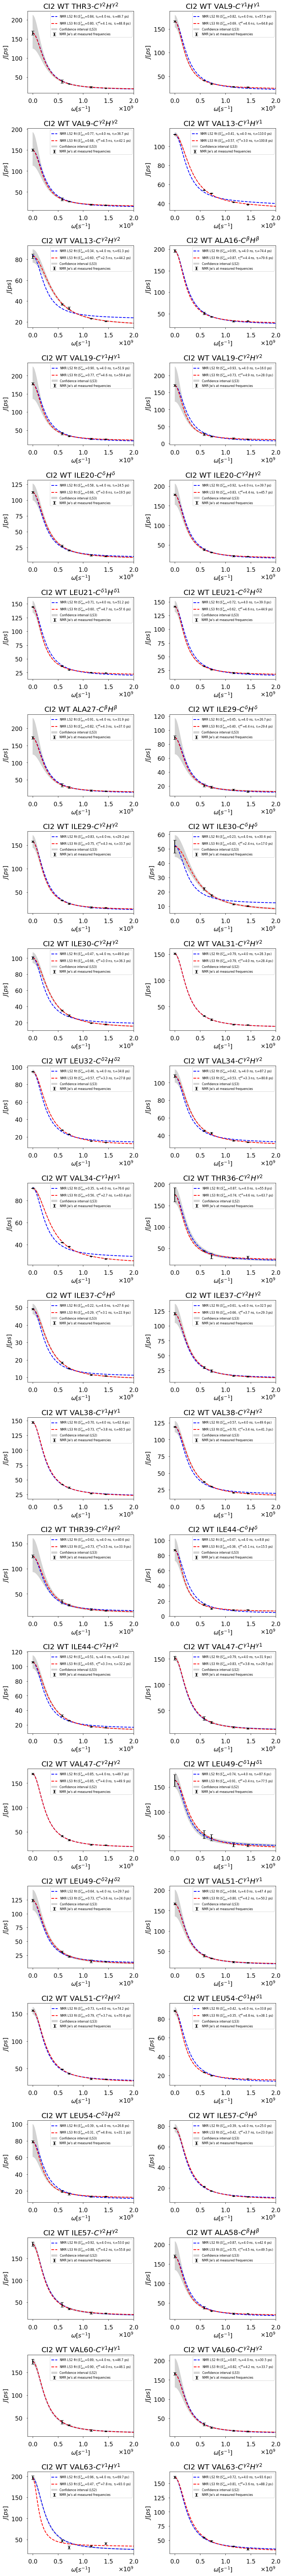

In [14]:
methID_dict = {"Ala":"ALA", "Ile":"ILE", "Leu":"LEU", "Met":"MET", "Thr":"THR", "Val":"VAL",
               "Cb":"-CB", "Hb":"HB", "Cg1":"-CG1","Cg2":"-CG2", "Hg1":"HG1","Hg2":"HG2","Cd1":"-CD1", "Hd1":"HD1",
               "Cd2":"-CD2", "Hd2":"HD2", "Ce":"-CE", "He":"HE"}
    
# Run a loop for all methyl groups:

fig1, axes1 = plt.subplots(nrows = round(data1.shape[0]/2), ncols = 2, figsize = (11, 105))
#j = 0
#print (axes1)
#print (axes1.flatten())
#a = enumerate(axes1.flatten())
#print (a)             

# 3 3 3 3 3 2 3 3 3 3 3 3 2 2 3 3 3 2 3 3 3 2 3 3 3 3 3 3 3 3 2 3 3 2 3 3 3 3 2 2 2 3 3 2 # LS for WT, L49I, I57V,
# 3 3 3 3 3 2 3 3 3 3 3 3 2 2 3 3 3 2 3 3 3 2 3 3 3 3 3 3 3 3 2 3 3 2 3 3 3 3 2 2 3 3 2 # LS for L49I_I57V

j=0
for i, ax in enumerate(axes1.flatten()):
#for j in range(np.size(data1,0)): 
#for j in range(8,9):
#     if j == np.size(data1,0): # j starts from 0 , not from 1 !
#         break
#for j in range(np.size(data1,0)): # for all methyl groups:
    Times=data1.iloc[i][::2].values # in ms
    Err = data1.iloc[i][1::2].values # in ms

    #methyl=np.array(data[methID])[1:] # numpy array with values from specific methyl group
    
    Rates = 1/(Times*0.001) # R1_600 R2_600 R3_600 R4_600 R1_750 R2_750 R3_750 R4_750
    Rates_err = np.divide(Err/0.001, Times**2) # R1_err_600 R2_err_600 R3_err_600 R4_err_600 R1_err_750 R2_err_750 R3_err_750 R4err_err_750

    Rates1to3 = np.array([Rates[0],Rates[1],Rates[2],Rates[4],Rates[5],Rates[6]])
    Rates_err1to3 = np.array([Rates_err[0],Rates_err[1],Rates_err[2],Rates_err[4],Rates_err[5],Rates_err[6]])
    
    
    Jzero_600=J_0(Rates[0],Rates[1],Rates[2]) 
    Jzero_750=J_0(Rates[4],Rates[5],Rates[6]) # J_0(R1,R2,R3)

    Jzero_600b=J_0_b(Rates[1],Rates[2],Rates[3]) 
    Jzero_750b=J_0_b(Rates[5],Rates[6],Rates[7]) # J_0_b(R2,R3,R4)

    Jw_D_600=J_omega_D(Rates[0],Rates[1],Rates[2]) 
    Jw_D_750=J_omega_D(Rates[4],Rates[5],Rates[6]) # J_omega_D(R1,R2,R3)
    
    J2w_D_600=J_2omega_D(Rates[0],Rates[1],Rates[2]) 
    J2w_D_750=J_2omega_D(Rates[4],Rates[5],Rates[6]) # J_2omega_D(R1,R2,R3)

    J2w_D_600b=J_2omega_D_b(Rates[1],Rates[2],Rates[3]) 
    J2w_D_750b=J_2omega_D_b(Rates[5],Rates[6],Rates[7]) # J_2omega_D_b(R2,R3,R4)

    
    ##############
    
    R1_exp_600 = Rates[0]; R2_exp_600 = Rates[1]; R3_exp_600 = Rates[2]; R4_exp_600 = Rates[3];
    R1_exp_750 = Rates[4]; R2_exp_750 = Rates[5]; R3_exp_750 = Rates[6]; R4_exp_750 = Rates[7];
    
    R1_err_exp_600 = Rates_err[0]; R2_err_exp_600 = Rates_err[1]; R3_err_exp_600 = Rates_err[2]; R4_err_exp_600 = Rates_err[3];
    R1_err_exp_750 = Rates_err[0]; R2_err_exp_750 = Rates_err[1]; R3_err_exp_750 = Rates_err[2]; R4_err_exp_750 = Rates_err[3];
      
    
    ## MINIMIZATION USING CHI^2 FUNCTION Chi2_Jpre
    ## DOES NOT WORK WITH LOW NUMBERS (10^-12). CONVERTED TO PICOSECONDS

    measuredfreq = np.array([measuredfreq_600[0],measuredfreq_600[1], measuredfreq_750[1], measuredfreq_600[2], measuredfreq_750[2]])
    
    Jomegas_pre = np.array([Jzero_600, Jw_D_600, Jw_D_750, J2w_D_600, J2w_D_750])*pre**2  # initial guess of Jomegas (x, y, z)
    #result1 = minimize(Chi2_J, Jomegas, method='nelder-mead', options={'disp': False})
    #print("Initial", Chi2_Jpre(Jomegas_pre))
    positive = { 'type': 'ineq', 'fun' : lambda x: np.array(x) }
    #positive = { 'type': 'ineq', 'fun' : lambda x: x[0] }
    opt = { 'maxiter': 500 , 'disp': False}
   
    result1 = optimize.minimize( Chi2_Jpre, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD = np.array([result1.x[0], result1.x[1], result1.x[2], result1.x[3], result1.x[4]])/pre**2
    
    resultA = optimize.minimize( Chi2_JpreA, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD_A = np.array([resultA.x[0], resultA.x[1], resultA.x[2], resultA.x[3], resultA.x[4]])/pre**2
        
    resultB = optimize.minimize( Chi2_JpreB, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD_B = np.array([resultB.x[0], resultB.x[1], resultB.x[2], resultB.x[3], resultB.x[4]])/pre**2
        
    resultC = optimize.minimize( Chi2_JpreC, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD_C = np.array([resultC.x[0], resultC.x[1], resultC.x[2], resultC.x[3], resultC.x[4]])/pre**2
    
    resultD = optimize.minimize( Chi2_JpreD, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD_D = np.array([resultD.x[0], resultD.x[1], resultD.x[2], resultD.x[3], resultD.x[4]])/pre**2
        
    resultE = optimize.minimize( Chi2_JpreE, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD_E = np.array([resultE.x[0], resultE.x[1], resultE.x[2], resultE.x[3], resultE.x[4]])/pre**2
        
    resultF = optimize.minimize( Chi2_JpreF, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD_F = np.array([resultF.x[0], resultF.x[1], resultF.x[2], resultF.x[3], resultF.x[4]])/pre**2
        
    resultG = optimize.minimize( Chi2_JpreG, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD_G = np.array([resultG.x[0], resultG.x[1], resultG.x[2], resultG.x[3], resultG.x[4]])/pre**2
        
    resultH = optimize.minimize( Chi2_JpreH, Jomegas_pre, jac = False, constraints = positive, method = 'SLSQP', options = opt )     
    JomegaD_H = np.array([resultH.x[0], resultH.x[1], resultH.x[2], resultH.x[3], resultH.x[4]])/pre**2

    
#     methIDtest = data1.index[j] 
#     #np.set_printoptions(suppress=True)
#     print('res', methIDtest)
#     print('Init', Jomegas_pre)
#     print('All', JomegaD)
#     print('A', JomegaD_A)
#     print('B', JomegaD_B)
#     print('C', JomegaD_C)
#     print('D', JomegaD_D)
#     print('E', JomegaD_E)
#     print('F', JomegaD_F)
#     print('G', JomegaD_G)
#     print('H', JomegaD_H)


    
# define error for JomegaD by minimizing Chi2_Jpre with different N [ (R_Jw - Rexp/Rexp_err)^2 elements ]
    
#  (chi2A)           (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+4*Jomegas_pre[3]))-R1_exp_600)/R1_err_exp_600)**2 + \
#  (chi2B)           (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[1]+6*Jomegas_pre[3]))-R2_exp_600)/R2_err_exp_600)**2 + \
#  (chi2C)           (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[1]+0*Jomegas_pre[3]))-R3_exp_600)/R3_err_exp_600)**2 + \
#  (chi2D)           (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[1]+2*Jomegas_pre[3]))-R4_exp_600)/R4_err_exp_600)**2 + \

#  (chi2E)           (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+4*Jomegas_pre[4]))-R1_exp_750)/R1_err_exp_750)**2 + \
#  (chi2F)           (((1./32.*(9*Jomegas_pre[0]+15*Jomegas_pre[2]+6*Jomegas_pre[4]))-R2_exp_750)/R2_err_exp_750)**2 + \
#  (chi2G)           (((3./16.*(0*Jomegas_pre[0]+ 3*Jomegas_pre[2]+0*Jomegas_pre[4]))-R3_exp_750)/R3_err_exp_750)**2 + \
#  (chi2H)           (((3./16.*(0*Jomegas_pre[0]+ 1*Jomegas_pre[2]+2*Jomegas_pre[4]))-R4_exp_750)/R4_err_exp_750)**2
    
# for Jw0      e.g. Jomegas_pre[0] B,F elements contain this Jw => at least one of them should be used in the minimization

# for JwD_600  e.g. Jomegas_pre[1] A,B,C,D
# for Jw2D_600 e.g. Jomegas_pre[3] A,B,C,D

# for JwD_750  e.g. Jomegas_pre[2] E,F,G,H
# for Jw2D_750 e.g. Jomegas_pre[4] E,F,G,H

# Since all Jw's are in at least one chi2 element, normal jackknife algortm can be used.



    ##############
     
    methID = data1.index[j] 
    
    match = re.search('(\d+)(\w{3})(\w+)_\d+\w{3}(\w+)', methID)
    resN = match.group(1) if match else None
    resName = match.group(2) if match else None
    carbon = match.group(3) if match else None
    hydrogen = match.group(4) if match else None
    #if (resN): print(resN)
    #if (resName): print(resName)
    #if (carbon): print(carbon)
    #if (hydrogen): print(hydrogen)
    
    methIDnew= " %s%s-%s%s" % (resName, resN, carbon, hydrogen)
    
    meth3ID = str(methID_dict[match.group(2)] + match.group(1) + methID_dict[match.group(3)] + methID_dict[match.group(4)])
    if resName=="Ile" and carbon=="Cd1":
        meth3ID=meth3ID.replace("-CD1HD1","-CDHD")
        
                
    with open(tumbling_file) as origin_file: # extract tumbling time from external tumbling
        for line in origin_file:
            #methylID = re.findall(meth3ID, line)
            #if (methylID): print(line)

            match = re.search('(\d+\.\d+)\s*\t*\[(\w{3}\d+\-\w+\d*\w+\d*)\]', line) # 4024.462292 [ILE30-CG2HG2]
            methylID = match.group(2) if match else None
            #if (methylID): print(methylID)
            if methylID:
                #line = line.split(' ')[3].split('\t')[0]
                #line = line.split(' ')[0]
                line = match.group(1) if match else None
# !! pico vs nano in input
                taum=float(line)*1000*pico
                #taum=float(line)*pico
                #print(line, methylID, taum)
                
    ##LS2
    
    LS2 = lambda p,x: 2./5.*(1./9.*p[0]*taum/(1.+(x*taum)**2)+(1.-1./9.*p[0])*taum*p[1]/(taum+p[1]+(x*taum*p[1])**2/(taum+p[1]))) # Lipari-Szabo function
    errLS2func = lambda p, x, y: LS2(p, x) - y # Distance to the target function
    taumps=taum/pico
    p02 = [0.5, 50] # Initial guess for the parameters
    bounds2_min = [0.,0.]
    bounds2_max = [1.,taumps]
    bounds2 = [bounds2_min, bounds2_max]
    LS2ns = lambda p,x: 2./5.*(1./9.*p[0]*taumps/(1.+(x*taumps)**2)+(1.-1./9.*p[0])*taumps*p[1]/(taumps+p[1]+(x*taumps*p[1])**2/(taumps+p[1]))) # Lipari-Szabo function in ns
    errLS2nsfunc = lambda p, x, y: LS2ns(p, x) - y # Distance to the target function
    p2 = optimize.least_squares(errLS2nsfunc, p02, bounds=bounds2, args=(measuredfreq*pico, JomegaD/pico)) # fit with LS2 function
    p2x=np.array([float(p2.x[0]), float(p2.x[1]*pico)])
    
    #print (errLS2nsfunc(p,x,y))
    #print (p2x)
    #print (p2)
    
    
#     # This can be used to estimate the Covariance Matrix of the parameters using the following formula: Sigma = (J'J)^-1.
#     J = p2.jac
#     cov = np.linalg.inv(J.T.dot(J))
#     # To find the variance of the parameters one can then use:
#     var = np.sqrt(np.diagonal(cov))
#     #print (var)

    ##LS3

    LS3 = lambda p,x: 2./5.*(1./9.*p[0]*p[2]/(1.+(x*p[2])**2)+(1.-1./9.*p[0])*p[2]*p[1]/(p[2]+p[1]+(x*p[2]*p[1])**2/(p[2]+p[1]))) # Lipari-Szabo function
    errLS3func = lambda p, x, y: LS2(p, x) - y # Distance to the target function
    p03 = [0.5, 100, 5000] # Initial guess for the parameters
    bounds3_min = [0.,0., 1000.]
    bounds3_max = [1.,500,10000]
    bounds3 = [bounds3_min, bounds3_max]
    LS3ns = lambda p,x: 2./5.*(1./9.*p[0]*p[2]/(1.+(x*p[2])**2)+(1.-1./9.*p[0])*p[2]*p[1]/(p[2]+p[1]+(x*p[2]*p[1])**2/(p[2]+p[1]))) # Lipari-Szabo function
    errLS3nsfunc = lambda p, x, y: LS3ns(p, x) - y # Distance to the target function
    p3 = optimize.least_squares(errLS3nsfunc, p03, bounds=bounds3, args=(measuredfreq*pico, JomegaD/pico)) # fit with LS3 function
    p3x=np.array([float(p3.x[0]), float(p3.x[1]*pico), float(p3.x[2]*pico)])

    ##
    rate1_600=R1(JomegaD[0],JomegaD[1],JomegaD[3]) # calculation of relaxation rates
    rate2_600=R2(JomegaD[0],JomegaD[1],JomegaD[3]) 
    rate3_600=R3(JomegaD[0],JomegaD[1],JomegaD[3])
   
    rate1_750=R1(JomegaD[0],JomegaD[2],JomegaD[4])
    rate2_750=R2(JomegaD[0],JomegaD[2],JomegaD[4]) 
    rate3_750=R3(JomegaD[0],JomegaD[2],JomegaD[4])
     
    Jw1LS2_600=LS2(p2x,measuredfreq)[0] # calculation of spectral density values at measured frequencies for LS2/LS3
    Jw2LS2_600=LS2(p2x,measuredfreq)[1]
    Jw3LS2_600=LS2(p2x,measuredfreq)[3]
    
    Jw1LS2_750=LS2(p2x,measuredfreq)[0] 
    Jw2LS2_750=LS2(p2x,measuredfreq)[2]
    Jw3LS2_750=LS2(p2x,measuredfreq)[4] 
    
    Jw1LS3_600=LS3(p3x,measuredfreq)[0]
    Jw2LS3_600=LS3(p3x,measuredfreq)[1]
    Jw3LS3_600=LS3(p3x,measuredfreq)[3]
    
    Jw1LS3_750=LS3(p3x,measuredfreq)[0]
    Jw2LS3_750=LS3(p3x,measuredfreq)[2]
    Jw3LS3_750=LS3(p3x,measuredfreq)[4]
    
    rate1LS2_600=R1(Jw1LS2_600,Jw2LS2_600,Jw3LS2_600) # rates from LS2/LS3
    rate2LS2_600=R2(Jw1LS2_600,Jw2LS2_600,Jw3LS2_600)
    rate3LS2_600=R3(Jw1LS2_600,Jw2LS2_600,Jw3LS2_600)
    
    rate1LS2_750=R1(Jw1LS2_750,Jw2LS2_750,Jw3LS2_750) 
    rate2LS2_750=R2(Jw1LS2_750,Jw2LS2_750,Jw3LS2_750)
    rate3LS2_750=R3(Jw1LS2_750,Jw2LS2_750,Jw3LS2_750)
    
    rate1LS3_600=R1(Jw1LS3_600,Jw2LS3_600,Jw3LS3_600)
    rate2LS3_600=R2(Jw1LS3_600,Jw2LS3_600,Jw3LS3_600)
    rate3LS3_600=R3(Jw1LS3_600,Jw2LS3_600,Jw3LS3_600)
    
    rate1LS3_750=R1(Jw1LS3_750,Jw2LS3_750,Jw3LS3_750)
    rate2LS3_750=R2(Jw1LS3_750,Jw2LS3_750,Jw3LS3_750)
    rate3LS3_750=R3(Jw1LS3_750,Jw2LS3_750,Jw3LS3_750)
    
    ratesanalytical=[rate1_600,rate2_600,rate3_600,rate1_750,rate2_750,rate3_750] # rates directly from TCF
    
    ratesLS2=[rate1LS2_600,rate2LS2_600,rate3LS2_600,rate1LS2_750,rate2LS2_750,rate3LS2_750] 
    ratesLS3=[rate1LS3_600,rate2LS3_600,rate3LS3_600,rate1LS3_750,rate2LS3_750,rate3LS3_750] 
    
    AIC_LS2 = CHIsq(ratesLS2,Rates1to3,Rates_err1to3) + 2*2 # CHIsqrt(Rmodel,Rnmr,Rerror)
    AIC_LS3 = CHIsq(ratesLS3,Rates1to3,Rates_err1to3) + 3*2 # CHIsqrt(Rmodel,Rnmr,Rerror)
    
    # JomegaD_stdv = - define 
    #
    
    stdvLS2 = STDV(JomegaD[0],JomegaD[1],JomegaD[3],JomegaD[2],JomegaD[4],Jw1LS2_600,Jw2LS2_600,Jw3LS2_600,Jw2LS2_750,Jw3LS2_750)
    stdvLS3 = STDV(JomegaD[0],JomegaD[1],JomegaD[3],JomegaD[2],JomegaD[4],Jw1LS3_600,Jw2LS3_600,Jw3LS3_600,Jw2LS3_750,Jw3LS3_750)
    
    Jw0_ErrChi2 = ERRCHI2(result1.x[0],resultA.x[0],resultB.x[0],resultC.x[0],resultD.x[0],resultE.x[0],resultF.x[0],resultG.x[0],resultH.x[0])
    JwD_600_ErrChi2 = ERRCHI2(result1.x[1],resultA.x[1],resultB.x[1],resultC.x[1],resultD.x[1],resultE.x[1],resultF.x[1],resultG.x[1],resultH.x[1])
    JwD2_600_ErrChi2 = ERRCHI2(result1.x[2],resultA.x[2],resultB.x[2],resultC.x[2],resultD.x[2],resultE.x[2],resultF.x[2],resultG.x[2],resultH.x[2])
    JwD_750_ErrChi2 = ERRCHI2(result1.x[3],resultA.x[3],resultB.x[3],resultC.x[3],resultD.x[3],resultE.x[3],resultF.x[3],resultG.x[3],resultH.x[3])
    JwD2_750_ErrChi2 = ERRCHI2(result1.x[4],resultA.x[4],resultB.x[4],resultC.x[4],resultD.x[4],resultE.x[4],resultF.x[4],resultG.x[4],resultH.x[4])
    
    err_Jws = np.array([Jw0_ErrChi2,JwD_600_ErrChi2,JwD2_600_ErrChi2,JwD_750_ErrChi2,JwD2_750_ErrChi2]) 
    #print(stdvLS2, Jw0_ErrChi2)
    
    ### MONTE CARLO TO DEFINE PARAMETERS (S2, tauf) ERRORS, SAVE PARAMETERS TO THE FILES      
    
    if AIC_LS2<=AIC_LS3: 
        LSns_MC = LS2ns_MC
        stdvLS = stdvLS2
        vGuess = [0.5,50]
        #stdv = np.array([stdvLS2,stdvLS2,stdvLS2,stdvLS2,stdvLS2])/pico
        errLSXfunc = errLS2func
        errLSXnsfunc = errLS2nsfunc
        boundsx = bounds2
        p00 = p02
    else:
        LSns_MC = LS3ns_MC
        stdvLS = stdvLS3
        vGuess = [0.5,100,5000]
        #stdv = np.array([stdvLS3,stdvLS3,stdvLS3,stdvLS3,stdvLS3])/pico
        errLSXfunc = errLS3func
        errLSXnsfunc = errLS3nsfunc
        boundsx = bounds3
        p00 = p03
        
    sErrorOld = stdvLS/pico
    
    #sError = np.mean(err_Jws)
    sError = err_Jws
    
    #print(sErrorOld, sError)

#################################    
    nTrials = 4000
    #print ("MC Trials =", nTrials)
    aFitPars = np.array([])
    

    
    for iTrial in range(nTrials):
        xTrial = measuredfreq*pico
        yGen = JomegaD/pico
        yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))

        # We use a try/except clause to catch pathologies
        try:                
                vTrial, aCova = optimize.curve_fit(LSns_MC,xTrial,yTrial,vGuess)
                #vTrial1 = optimize.least_squares(errLSXnsfunc, p00, bounds=boundsx, args=(measuredfreq*pico, yTrial)) # fit with LS2/LS3 function
                #vTrial = vTrial1.x
        except:
            #dumdum=1
            continue  # This moves us to the next loop without stacking.
            
        #here follows the syntax for stacking the trial onto the running sample:
        if np.size(aFitPars) < 1:
            aFitPars=np.copy(vTrial)
            #print (vTrial)
        else:
            aFitPars = np.vstack(( aFitPars, vTrial ))
            #print (vTrial)            
            
#     ax = plt.subplot(211)
#     ax.hist(aFitPars[:,0],bins=50)
    
#     ax1 = plt.subplot(212)
#     ax1.hist(aFitPars[:,1],bins=50, facecolor='orange')
    
    #print ('aFitPars',aFitPars)
    S2_tauf_MC_std=np.array([float(np.median(aFitPars[:,0])), float(np.std(aFitPars[:,0])), \
                             float(np.median(aFitPars[:,1])), float(np.std(aFitPars[:,1]))])
    
    if AIC_LS2<=AIC_LS3:
        S2_tauf_MC_stdOnly=np.array([float(np.std(aFitPars[:,0])), float(np.std(aFitPars[:,1]))*pico])
        
        #print ("std", S2_tauf_MC_stdOnly)
        p2x_min = p2x-S2_tauf_MC_stdOnly
        p2x_max = p2x+S2_tauf_MC_stdOnly
        #print('p2x: ',p2x)        
        #print('p2x_min: ',p2x_min)
        #print(p2x_max)
        #test1 = LS2(p2x_min,frequency);
        #print('LS2 test: ', test1)
        
    else:
        S2_tauf_MC_stdOnly=np.array([float(np.std(aFitPars[:,0])), float(np.std(aFitPars[:,1]))*pico, float(np.std(aFitPars[:,2]))*pico])
        #S2_tauf_MC_stdOnly=np.array([float(np.std(aFitPars[:,0])), float(np.std(aFitPars[:,1]))*pico, 0])

        #print ("std", S2_tauf_MC_stdOnly)
        p3x_min = p3x-S2_tauf_MC_stdOnly
        p3x_max = p3x+S2_tauf_MC_stdOnly
        #print('p3x: ',p3x)
        #print('p3x_min: ',p3x_min)
        #print('p3x_max: ',p3x_max)
        #test1 = LS3(p3x_min,frequency);
        #print('LS3 test: ', test1)
    

    
    ### END MONTE CARLO ###

    values=[rate1_600,rate2_600,rate3_600,rate1_750,rate2_750,rate3_750,
            p2x[0],p2x[1],rate1LS2_600,rate2LS2_600,rate3LS2_600,rate1LS2_750,rate2LS2_750,rate3LS2_750,
            Jw1LS2_600,Jw2LS2_600,Jw3LS2_600,Jw1LS2_750,Jw2LS2_750,Jw3LS2_750,
            p3x[0],p3x[2],p3x[1],rate1LS3_600,rate2LS3_600,rate3LS3_600,rate1LS3_750,rate2LS3_750,rate3LS3_750,
            Jw1LS3_600,Jw2LS3_600,Jw3LS3_600,Jw1LS3_750,Jw2LS3_750,Jw3LS3_750,AIC_LS2,AIC_LS3] # all results in one array
    
#   indices=["R1spec","R2spec","R3spec", 
#          "SLS2","taufLS2","R1LS2_600","R2LS2_600","R3LS2_600","R1LS2_750","R2LS2_750","R3LS2_750",
#          "Jw1LS2_600","Jw2LS2_600","Jw3LS2_600","Jw1LS2_750","Jw2LS2_750","Jw3LS2_750",
#          "SLS3","taurLS3","taufLS3","R1LS3_600","R2LS3_600","R3LS3_600","R1LS3_750","R2LS3_750","R3LS3_750",
#          "Jw1LS3_600","Jw2LS3_600","Jw3LS3_600","Jw1LS3_750","Jw2LS3_750","Jw3LS3_750"]
 
    
    #if plotting:
    output=pd.DataFrame(values,indices) # dataframe describing the output which will be written to the file
    output.to_csv(outputpath+"/params_"+meth3ID,sep=" ", header=False) # write values to file

    j += 1    
    # PLOTTING
    
    # Make a dictionary for latex formatting in the plot titles:
    latex_title = {"CBHB": r"-$C^{\beta}H^{\beta}$",
                   "CDHD": r"-$C^{\delta}H^{\delta}$",
                   "CEHE": r"-$C^{\epsilon}H^{\epsilon}$",
                   "CD1HD1": r"-$C^{\delta1}H^{\delta1}$",
                   "CD2HD2": r"-$C^{\delta2}H^{\delta2}$",
                   "CG1HG1": r"-$C^{\gamma1}H^{\gamma1}$",
                   "CG2HG2": r"-$C^{\gamma2}H^{\gamma2}$"}

    
    if plotting:
        plt.figure(figsize=(6,4))
        edge=0.2
        ax = plt.subplot(111)
        plt.subplots_adjust(bottom=edge, left=edge)
        ax.tick_params(pad=10)
        #plt.title(mutant[:3]+" "+mutant[-2:]+" "+meth3ID, fontsize=20)
        plt.title(mutant[:3]+" "+mutant[4:]+" "+meth3ID.split("-")[0]+latex_title[meth3ID.split("-")[1]], fontsize=20)

        #plt.plot(frequency, specfunc(frequency)/pico, label="FT of MD data fit",c="r") 
        plt.plot(frequency, LS2(p2x, frequency)/pico, c="b", linestyle="--", label=r'NMR LS2 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p2x[0],2))+r', $\tau_\mathrm{R}$='+str("%.1f" % round(taum/1000/pico,1))+r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p2x[1]/pico,1))+r' ps)')
        
        if AIC_LS2<=AIC_LS3:
            plt.fill_between(frequency,LS2(p2x_min,frequency)/pico,LS2(p2x_max,frequency)/pico,facecolor='lightgrey', interpolate=True, edgecolors="None",label="Confidence interval (LS2)")        
        else:
            plt.fill_between(frequency,LS3(p3x_min,frequency)/pico,LS3(p3x_max,frequency)/pico,facecolor='lightgrey', interpolate=True, edgecolors="None",label="Confidence interval (LS3)")        

            
        plt.plot(frequency, LS3(p3x, frequency)/pico, c="r", linestyle="--", label=r'NMR LS3 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p3x[0],2))+r', $\tau_\mathrm{c}^\mathrm{eff}$='+str("%.1f" % round(p3.x[2]/1000,1))+r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p3.x[1],1))+r' ps)') # Plot of the data and the fit
        plt.errorbar(measuredfreq, JomegaD/pico, yerr=err_Jws, c="k", linestyle="None", fmt='o', capsize = 4, label="NMR Jw's at measured frequencies", ms=3)
        plt.xlabel(r'$\omega [s^{-1}]$')
        plt.ylabel(r'$J[ps]$')
        ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        plt.xlim(-10**8,2*10**9)
        plt.legend(numpoints=1, fontsize=8)
        plt.savefig(outputpath+"/spec_dens_"+meth3ID+".png",dpi=600)
        #plt.savefig(outputpath+"/spec_dens_"+meth3ID+".pdf",dpi=1200)
        plt.close()

            # Plot spectral density:
    if subplots:
        #fname = "specdens_all.pdf"
        #edge=0.2
        #ax = plt.subplot(111)
        ax = plt.subplot(round(data1.shape[0]/2), 2, j)
        #plt.subplots_adjust(bottom=edge, left=edge)
        #plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
        plt.subplots_adjust(top=0.99, right=0.99)
        ax.tick_params(pad=10)
        
        #ax.plot(measuredfreq, JomegaD/pico, "rv", label="NMR optimized Jw's at measured frequencies", ms=8)
        ax.plot(frequency, LS2(p2x, frequency)/pico, c="b", linestyle="--", label=r'NMR LS2 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p2x[0],2))+r', $\tau_\mathrm{R}$='+str("%.1f" % round(taum/1000/pico,1))+r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p2x[1]/pico,1))+r' ps)')
        
        if AIC_LS2<=AIC_LS3:
            ax.fill_between(frequency,LS2(p2x_min,frequency)/pico,LS2(p2x_max,frequency)/pico,facecolor='lightgrey', interpolate=True, edgecolors="None",label="Confidence interval (LS2)")        
        else:
            ax.fill_between(frequency,LS3(p3x_min,frequency)/pico,LS3(p3x_max,frequency)/pico,facecolor='lightgrey', interpolate=True, edgecolors="None",label="Confidence interval (LS3)")        

        
        ax.plot(frequency, LS3(p3x, frequency)/pico, c="r", linestyle="--", label=r'NMR LS3 fit ($S^\mathrm{2}_\mathrm{axis}$='+str("%.2f" % round(p3x[0],2))+r', $\tau_\mathrm{c}^\mathrm{eff}$='+str("%.1f" % round(p3.x[2]/1000,1))+r' ns, $\tau_\mathrm{f}$='+str("%.1f" % round(p3.x[1],1))+r' ps)') # Plot of the data and the fit
        ax.errorbar(measuredfreq, JomegaD/pico, yerr=err_Jws, c="k", linestyle="None", fmt='o', capsize = 4, label="NMR Jw's at measured frequencies", ms=3)

        ax.set_xlabel(r'$\omega [s^{-1}]$')
        ax.set_ylabel(r'$J[ps]$')
        #ax.set_title("CI2 WT "+meth3ID, fontsize=20)
        #ax.set_title(mutant[:3]+" "+mutant[-2:]+" "+meth3ID, fontsize=20)
        plt.title(mutant[:3]+" "+mutant[4:]+" "+meth3ID.split("-")[0]+latex_title[meth3ID.split("-")[1]], fontsize=20)

        ax.xaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        ax.yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
        plt.xlim(-10**8,2*10**9)
        plt.legend(numpoints=1, fontsize=8, loc = 1)
   
        
        #print ("#", j) 
    #with open("/Users/psz898/OneDrive/Documents/SCIENCE/UCPH/Reports/CI2_summary/ci2_nmr_relax_output/order_"+mutant+"_methyl_chi2.dat", 'w+') as f:
       
        #order_new = pd.DataFrame([float(p2x[0])],index = [meth3ID]) # order parameter for this methyl group
    #if AIC_LS2<=AIC_LS3:
    #        order_new=pd.DataFrame([float(p2x[0])],index=[meth3ID]) # order parameter for this methyl group
    #        print (j,"\t",meth3ID,"\t","S2", "%.2f" % p2x[0],"+/-", "%.3f" % S2_tauf_MC_std[1],"tau_f", "%1.2f" % p2.x[1],"+/-", "%.2f" % S2_tauf_MC_std[3] ,"LS2 AIC", "%.2f" % AIC_LS2)
    #        # add errors for S2
    #        # add file with tauf and errors
    #        # file with S2, err, tauf, err, LS2 AIC LS3 AIC LS_chosen AIC_chosen
    #else:
    #        order_new=pd.DataFrame([float(p3x[0])],index=[meth3ID])
    #        print (j,"\t",meth3ID,"\t","S2", "%.2f" % p3x[0],"+/-", "%.3f" % S2_tauf_MC_std[1],"tau_f", "%1.2f" % p3.x[1],"+/-", "%.2f" % S2_tauf_MC_std[3] ,"LS3 AIC", "%.2f" % AIC_LS3)
    #order=order.append(order_new) # append order parameter to dataframe containing all order parameters
    
    order_new = pd.DataFrame(columns = ["methylID_full", "S2_LS2", "AIC_LS2", "S2_LS3", "AIC_LS3", "LS", "AIC", "S2", "S2_er", "tauf", "tauf_er"])
  
    if AIC_LS2<=AIC_LS3:
        order_new = order_new.append(pd.DataFrame({"methylID_full": meth3ID, "S2_LS2":[float(p2x[0])],"AIC_LS2": AIC_LS2, 
                                                       "S2_LS3":[float(p3x[0])],"AIC_LS3": AIC_LS3,"LS":"LS2","AIC":AIC_LS2, "S2":[float(p2x[0])],"S2_er":[float(S2_tauf_MC_std[1])], 
                                                       "tauf":p2.x[1],"tauf_er": S2_tauf_MC_std[3]}, index = [0]), ignore_index = True, sort=False)
        
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % p2x[0],"+/-", "%.3f" % S2_tauf_MC_std[1],"tau_f", "%1.2f" % p2.x[1],"+/-", "%.2f" % S2_tauf_MC_std[3] ,"LS2 AIC", "%.2f" % AIC_LS2)

    else:
        order_new = order_new.append(pd.DataFrame({"methylID_full": meth3ID, "S2_LS2":[float(p2x[0])],"AIC_LS2": AIC_LS2, 
                                                       "S2_LS3":[float(p3x[0])],"AIC_LS3": AIC_LS3,"LS":"LS3","AIC":AIC_LS3, "S2":[float(p3x[0])],"S2_er":[float(S2_tauf_MC_std[1])], 
                                                       "tauf":p3.x[1],"tauf_er": S2_tauf_MC_std[3]}, index = [0]), ignore_index = True, sort=False)
        
        print (j,"\t",meth3ID,"\t","S2", "%.2f" % p3x[0],"+/-", "%.3f" % S2_tauf_MC_std[1],"tau_f", "%1.2f" % p3.x[1],"+/-", "%.2f" % S2_tauf_MC_std[3] ,"LS3 AIC", "%.2f" % AIC_LS3)

        
    order = order.append(order_new) # append order parameter to dataframe containing all order parameter

order.to_csv(outputpath+"/order_"+mutant+"_methyl.dat",header=True,sep="\t", float_format='%5.3f') # write order parameter to file
print ("Printing the plots...")

if subplots:
    #plt.savefig(outputpath+"/spec_dens_"+meth3ID+".png",dpi=600)
    #plt.savefig(outputpath+"/spec_dens_"mutant[:3]+" "+mutant[-2:]+".pdf",dpi=1200)        
    fig1.tight_layout(rect=[0, 0.03, 1, 0.96])
    fig1.savefig(str(outputpath+"/"+mutant+"_spec_dens.pdf"), dpi = 1200, bbox_inches='tight') 
     